In [25]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import itertools
import os
from os import path
import json

In [45]:
#policies = ["ondemand", "conservative", "performance", "schedutil", "powersave", "userspace"]
policies = ["ondemand"]

# total time to run for, in ms
times = [600000]

# diff flink rates
rates = [i for i in range(100000,500000,100000)] #2100 because python excludes last value.

# number of mappers
#mappers = [4,8,12,16]
mappers = [4]

data/query1_cores16_frate100000_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper4_sink16_repeat0
data/query1_cores16_frate200000_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper4_sink16_repeat0
data/query1_cores16_frate300000_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper4_sink16_repeat0
data/query1_cores16_frate400000_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper4_sink16_repeat0


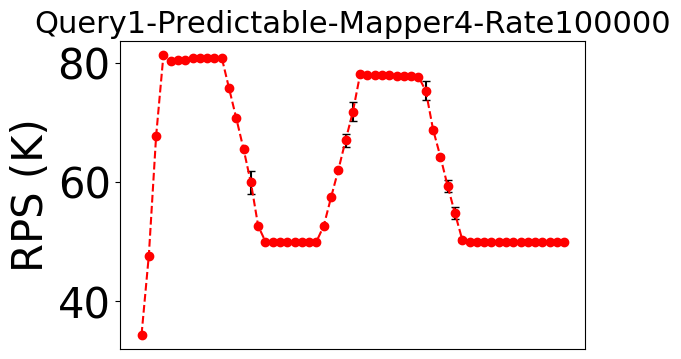

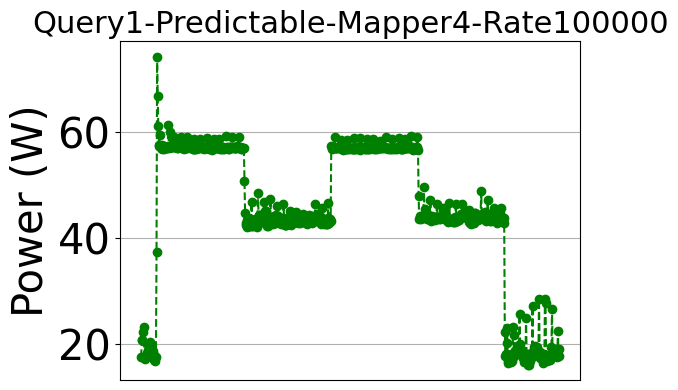

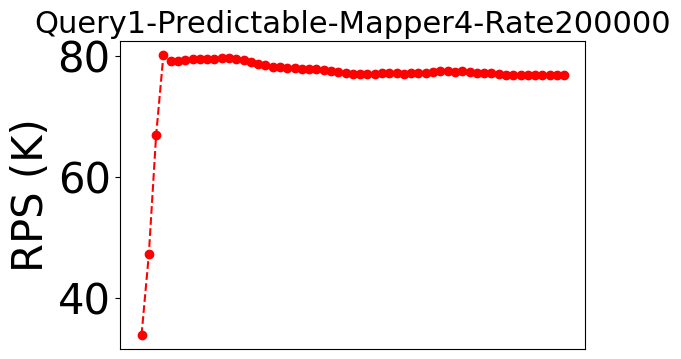

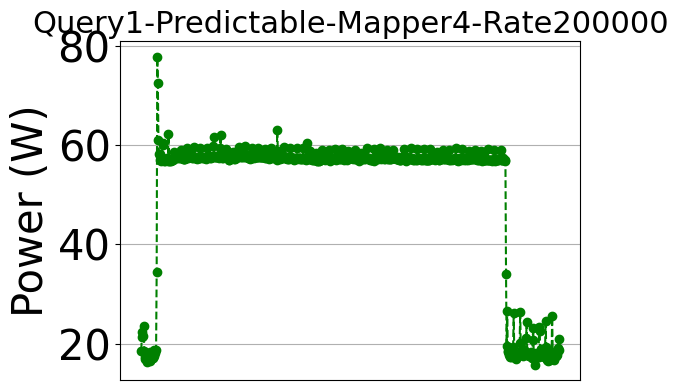

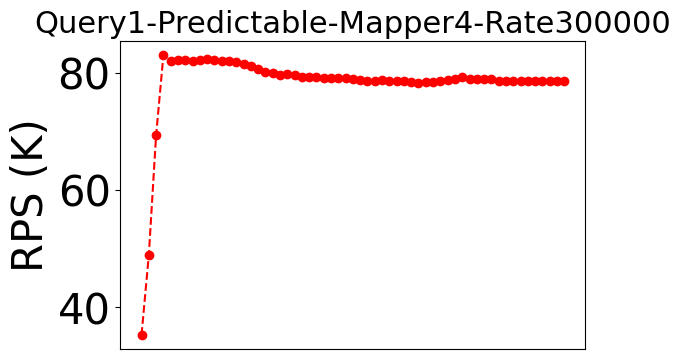

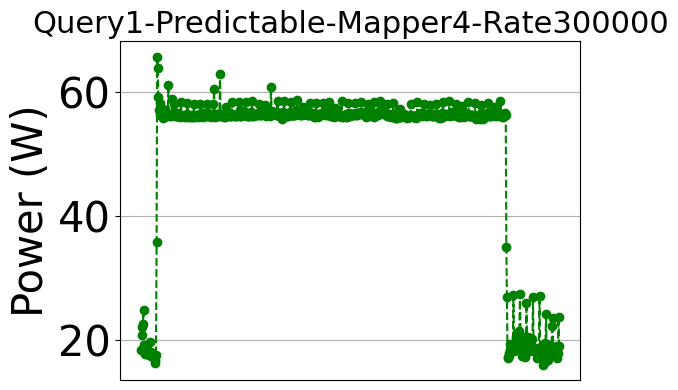

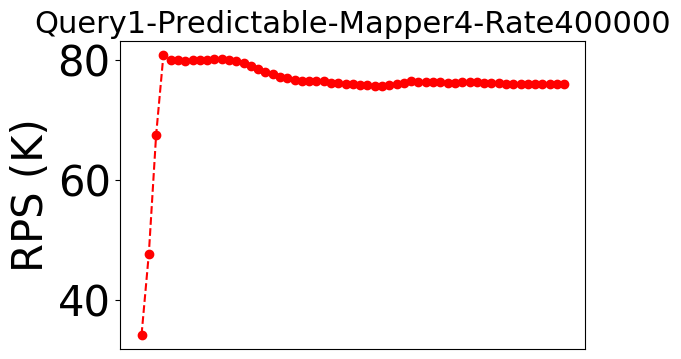

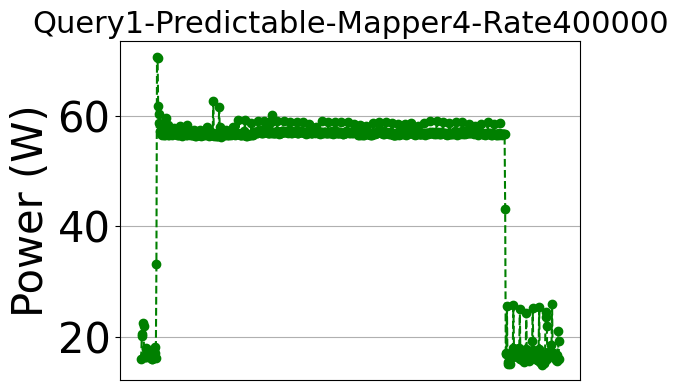

In [54]:
def parseLog(loc):
    ncores=16
    arr = []
    for i in range(0, ncores):
        arr.append([])
        srcf = f"{loc}/Flinklogs/Operator_Source: Bids Source_{i}"
        with open(srcf) as file:
            lines = [line.rstrip().split(';')[9] for line in file]
            for l in lines:
                if 'numRecordsOutPerSecond' in l:
                    jo = l[2:-1].replace("'", '"')
                    jo = json.loads(jo)
                    arr[i].append(float(jo['value'])/1000.0)
    minl = 9999
    for i in range(0, len(arr)):
        minl = min(minl, len(arr[i]))

    arrmean = []
    arrstd = []
    for i in range(0, minl):
        arrv = []
        for c in range(0, ncores):
            arrv.append(arr[c][i])
        arrmean.append(round(np.mean(arrv), 2))
        arrstd.append(round(np.std(arrv), 2))
    return arrmean, arrstd
            
combinations = list(itertools.product(policies, rates, times, mappers))

def parseRapl(loc):
    raplf = f"{loc}/rapl.log"
    with open(raplf) as file:
        lines = [float(line.rstrip().split(' ')[0]) for line in file]
    #print(lines)
    return lines

# Print the combinations
for combo in combinations:
    policy, rate, timems, mapper = combo
    loc=f"data/query1_cores16_frate{rate}_{timems}_fratetype_predictable_fbuff-1_itr{1}_{policy}dvfs{1}_source{16}_mapper{mapper}_sink{16}_repeat{0}"
    if not path.exists(loc+ "/summary.csv"):
        break
    print(loc)

    plt.rcParams['figure.figsize'] = 6, 4
    plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=30)    # fontsize of the tick labels

    fig, ax = plt.subplots()
    amean, astd = parseLog(loc)
    ax.errorbar(np.arange(len(amean)), amean, yerr=astd, capsize=3, fmt="r--o", ecolor = "black")
    ax.set_ylabel('RPS (K)')
    ax.set_title(f"Query1-Predictable-Mapper{mapper}-Rate{rate}", size=22)
    ax.set_xticks([])
    
    fig, ax = plt.subplots()
    raplg = parseRapl(loc)
    ax.errorbar(np.arange(len(raplg)), raplg, capsize=3, fmt="g--o", ecolor = "black")
    ax.set_ylabel('Power (W)')
    ax.set_title(f"Query1-Predictable-Mapper{mapper}-Rate{int(rate/1000)K}", size=22)
    ax.set_xticks([])
    
    plt.grid()
    plt.tight_layout()
    